# Grover's Algorithm
Unstructured searches with quadratic speedup

Source: https://qiskit.org/textbook/ch-algorithms/grover.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

from qiskit.visualization import plot_histogram

In [2]:
#prep a quantum circuit with 2 qubits
n = 2
grover_circuit = QuantumCircuit(n)

In [3]:
#define a function to initialize the state we want
def initialize_s(qc, qubits):
    for q in qubits:
        qc.h(q)
    return qc

In [4]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

In [5]:
#apply a controlled-z gate
grover_circuit.cz(0,1)
grover_circuit.draw()

┌───┐   
q_0: ┤ H ├─■─
     ├───┤ │ 
q_1: ┤ H ├─■─
     └───┘

In [6]:
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])

grover_circuit.draw()

┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

#### Experiment with Simulators

In [7]:
sim = Aer.get_backend('aer_simulator')

#make a copy of the circuit with the 'save_statevector' instruction to run on the Aer sim
grover_circuit_sim = grover_circuit.copy()
grover_circuit_sim.save_statevector()

qobj = assemble(grover_circuit_sim)
result = sim.run(qobj).result()

statevec = result.get_statevector()

In [8]:
from qiskit_textbook.tools import vector2latex

vector2latex(statevec, pretext = "|\\psi\\rangle = ")

<IPython.core.display.Math object>

As seen in the statevector, the amplitude of every state that is not |11> is 0, so we have a 100% chance of measuring |11>

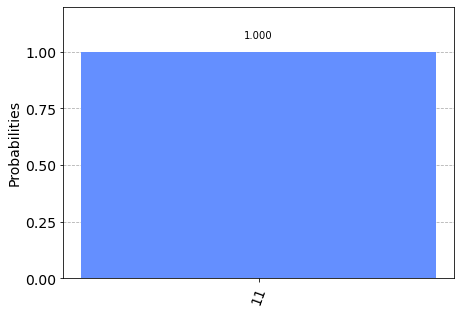

In [9]:
grover_circuit.measure_all

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_circuit_sim)

############ 
# NOTE
#the textbook uses grover_circuit above instead of grover_circuit_sim
#and that produces an error
############

result = aer_sim.run(qobj).result()
counts = result.get_counts()

plot_histogram(counts)

#### Experiment with real devices

In [10]:
from qiskit.tools.monitor import job_monitor

In [11]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")

device = least_busy(provider.backends(
                filters=lambda x: x.configuration().n_qubits >= 3 and 
                not x.configuration().simulator and x.status().operational==True))

print(f"Least busy device: {device}")

Least busy device: ibmq_quito


In [12]:
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level = 3)

job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


ValueError: max() arg is an empty sequence

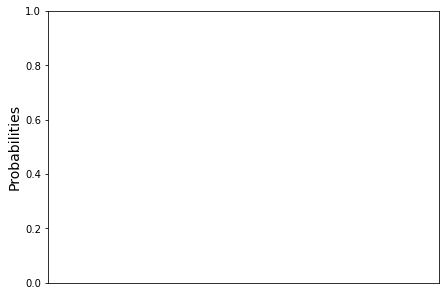

In [13]:
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

#### 3 qubits

In [20]:
qc = QuantumCircuit(3)
qc.cz(0,2)
qc.cz(1,2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U_$\omega$"

In [21]:
#create a general diffuser
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    
    #apply transformation to initial states
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    
    #multicontrolled Z-gate
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits-1)),nqubits-1)
    qc.h(nqubits - 1)
    
    #apply transformation 1 to 0
    for qubit in range(nqubits):
        qc.x(qubit)
    
    #return diffuser as a gte
    U_s = qc.to_gate()
    U_s.name="U$_S$"
    
    return U_s

In [22]:
n = 3

grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])

grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])

grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌─────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0            ├┤0       ├─░─┤M├──────
        ├───┤│             ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 U_$\omega$ ├┤1 U$_S$ ├─░──╫─┤M├───
        ├───┤│             ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2            ├┤2       ├─░──╫──╫─┤M├
        └───┘└─────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════╩══╩══╩═
                                          0  1  2

#### Experiment with simulators

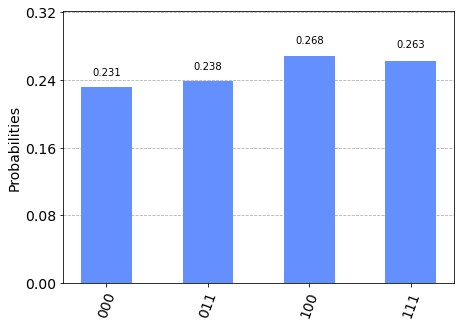

In [23]:
aer_sim = Aer.get_backend('aer_simulator')

transpiled_grover_circuit = transpile(grover_circuit,aer_sim)
qobj = assemble(transpiled_grover_circuit)

results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

#### Experiment with real devices

In [24]:
backend = least_busy(provider.backends(
    filters = lambda x: x.configuration().n_qubits >= 3 and
    not x.configuration().simulator 
    and x.status().operational == True))

print(f"Least busy backend: {backend}")

Least busy backend: ibmq_quito


In [25]:
transpiled_grover_circuit = transpile(grover_circuit, device,
                                     optimization_level = 3)

job = device.run(transpiled_grover_circuit)
job_monitor(job, interval = 2)

Job Status: job has successfully run


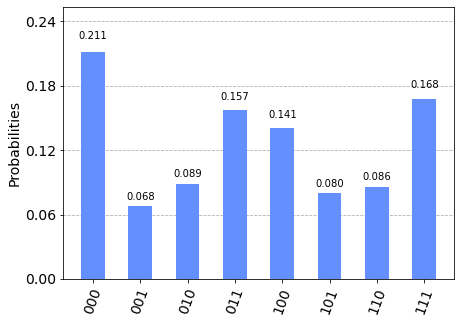

In [26]:
results = job.result()
answer = results.get_counts(grover_circuit)

plot_histogram(answer)

##### Example problem

In [27]:
from qiskit_textbook.problems import grover_problem_oracle

In [29]:
n = 4
oracle = grover_problem_oracle(n, variant=1)

qc = QuantumCircuit(n)
qc.append(oracle, [0,1,2,3])

qc.draw()

┌────────────────────┐
q_0: ┤0                   ├
     │                    │
q_1: ┤1                   ├
     │  Oracle
n=4, var=1 │
q_2: ┤2                   ├
     │                    │
q_3: ┤3                   ├
     └────────────────────┘

#### Sudoku with Grover's Algorithm
Since we need to check across both columns and rows, we have 4 conditions to check that these values are note equal:

- v0 ~=~ v1
    - check top row
- v2 ~=~ v3
    - check bottom row
- v0 ~=~ v2
    - check left column
- v1 ~=~ v3
    - check right column

In [30]:
clause_list = [[0,1],[0,2],[1,3],[2,3]]

In [31]:
#define an XOR function
def XOR(qc, a, b, output):
    qc.cx(a,output)
    qc.cx(b, output)

In [34]:
#use separate registers to name the bits
in_qubits = QuantumRegister(2,name='input')
out_qubits = QuantumRegister(1, name = 'output')

qc = QuantumCircuit(in_qubits, out_qubits)

XOR(qc, in_qubits[0], in_qubits[1], out_qubit)

qc.draw()

input_0: ──■───────
            │       
 input_1: ──┼────■──
          ┌─┴─┐┌─┴─┐
output_0: ┤ X ├┤ X ├
          └───┘└───┘

In [36]:
#repeat the circuit for each pairing in clause_list

var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')

qc = QuantumCircuit(var_qubits, clause_qubits)

In [38]:
#use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i+=1

qc.draw()

v_0: ──■─────────■───────────────────────────
       │         │                           
v_1: ──┼────■────┼─────────■─────────────────
       │    │    │         │                 
v_2: ──┼────┼────┼────■────┼─────────■───────
       │    │    │    │    │         │       
v_3: ──┼────┼────┼────┼────┼────■────┼────■──
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │  
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼──
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │  
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼──
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │  
c_2: ────────────────────┤ X ├┤ X ├──┼────┼──
                         └───┘└───┘┌─┴─┐┌─┴─┐
c_3: ──────────────────────────────┤ X ├┤ X ├
                                   └───┘└───┘

In [41]:
#now including an output_qubit
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')

qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

#use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i+=1

qc.mct(clause_qubits, output_qubit)
qc.draw()


v_0: ──■─────────■────────────────────────────────
         │         │                                
  v_1: ──┼────■────┼─────────■──────────────────────
         │    │    │         │                      
  v_2: ──┼────┼────┼────■────┼─────────■────────────
         │    │    │    │    │         │            
  v_3: ──┼────┼────┼────┼────┼────■────┼────■───────
       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       
  c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──
       └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  
  c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■──
                 └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │  
  c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──
                           └───┘└───┘┌─┴─┐┌─┴─┐  │  
  c_3: ──────────────────────────────┤ X ├┤ X ├──■──
                                     └───┘└───┘┌─┴─┐
out_0: ────────────────────────────────────────┤ X ├
                                               └───┘

###### Now we uncompute and complete the oracle

In [43]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name = 'cbits')

qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

In [46]:
def sudoku_oracle(qc, clause_list, clause_qubits):
    #compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i+=1
        
    #flip outout bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)
    
    #uncompute clauses to reset bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

In [47]:
sudoku_oracle(qc, clause_list, clause_qubits)

qc.draw()

»
    v_0: ──■─────────■──────────────────────────────────■─────────■────────────»
           │         │                                  │         │            »
    v_1: ──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──»
           │    │    │         │                        │    │    │         │  »
    v_2: ──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼──»
           │    │    │    │    │         │              │    │    │    │    │  »
    v_3: ──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼──»
         ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │  »
    c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼──»
         └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │  »
    c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼──»
                   └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐»
    c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├»
                             └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘»
    c_3: ──────────────────────────────┤ X ├┤ X ├──■───────────────────────────»
                                       └───┘└───┘┌─┴─┐                         »
  out_0: ────────────────────────────────────────┤ X ├─────────────────────────»
                                                 └───┘                         »
cbits: 4/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                        
«    v_0: ───────────────
«                        
«    v_1: ───────────────
«                        
«    v_2: ───────■───────
«                │       
«    v_3: ──■────┼────■──
«           │    │    │  
«    c_0: ──┼────┼────┼──
«           │    │    │  
«    c_1: ──┼────┼────┼──
«         ┌─┴─┐  │    │  
«    c_2: ┤ X ├──┼────┼──
«         └───┘┌─┴─┐┌─┴─┐
«    c_3: ─────┤ X ├┤ X ├
«              └───┘└───┘
«  out_0: ───────────────
«                        
«cbits: 4/═══════════════
«

#### The Full Algorithm
Now we just have to put the oracle into Grover's Algorithm:

In [65]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name = 'c')
output_qubit = QuantumRegister(1, name = 'out')
cbits = ClassicalRegister(4, name = 'cbits')

qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

#initialize 'out0' in state |-> and qubits in state |s>
qc.initialize([1, -1]/np.sqrt(2), output_qubit)
qc.h(var_qubits)
qc.barrier()

#first iteration, apply oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()
qc.append(diffuser(4), [0,1,2,3])

#second iteration, apply oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()
qc.append(diffuser(4), [0,1,2,3])

#measure
qc.measure(var_qubits, cbits)
qc.draw(fold = -1)

┌───┐               ░                                                                                       ░ ┌────────┐                                                                                      ░ ┌────────┐┌─┐         
    v_0: ─────────────┤ H ├───────────────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├──■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├┤M├─────────
                      ├───┤               ░   │         │                                  │         │                            ░ │        │  │         │                                  │         │                            ░ │        │└╥┘┌─┐      
    v_1: ─────────────┤ H ├───────────────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├─╫─┤M├──────
                      ├───┤               ░   │    │    │         │                        │    │    │         │                  ░ │  U$_S$ │  │    │    │         │                        │    │    │         │                  ░ │  U$_S$ │ ║ └╥┘┌─┐   
    v_2: ─────────────┤ H ├───────────────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├─╫──╫─┤M├───
                      ├───┤               ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │  │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │ ║  ║ └╥┘┌─┐
    v_3: ─────────────┤ H ├───────────────░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├─╫──╫──╫─┤M├
                      └───┘               ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘ ║  ║  ║ └╥┘
    c_0: ─────────────────────────────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░───────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░            ║  ║  ║  ║ 
    c_1: ─────────────────────────────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░─────────────────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░            ║  ║  ║  ║ 
    c_2: ─────────────────────────────────░─────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░───────────────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░────────────╫──╫──╫──╫─
                                          ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░                               └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░            ║  ║  ║  ║ 
    c_3: ─────────────────────────────────░───────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├─░─────────────────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├

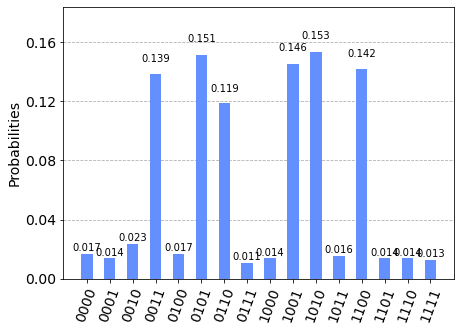

In [66]:
#simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)

result = aer_sim.run(qobj).result()
plot_histogram(result.get_counts())

In [67]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

┌───┐               ░                                                                                       ░ ┌────────┐                                                                                      ░ ┌────────┐┌─┐         
    v_0: ─────────────┤ H ├───────────────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├──■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├┤M├─────────
                      ├───┤               ░   │         │                                  │         │                            ░ │        │  │         │                                  │         │                            ░ │        │└╥┘┌─┐      
    v_1: ─────────────┤ H ├───────────────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├─╫─┤M├──────
                      ├───┤               ░   │    │    │         │                        │    │    │         │                  ░ │  U$_S$ │  │    │    │         │                        │    │    │         │                  ░ │  U$_S$ │ ║ └╥┘┌─┐   
    v_2: ─────────────┤ H ├───────────────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├─╫──╫─┤M├───
                      ├───┤               ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │  │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │ ║  ║ └╥┘┌─┐
    v_3: ─────────────┤ H ├───────────────░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├─╫──╫──╫─┤M├
                      └───┘               ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘ ║  ║  ║ └╥┘
    c_0: ─────────────────────────────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░───────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░            ║  ║  ║  ║ 
    c_1: ─────────────────────────────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░─────────────────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░            ║  ║  ║  ║ 
    c_2: ─────────────────────────────────░─────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░───────────────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░────────────╫──╫──╫──╫─
                                          ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░                               └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░            ║  ║  ║  ║ 
    c_3: ─────────────────────────────────░───────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├─░─────────────────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├

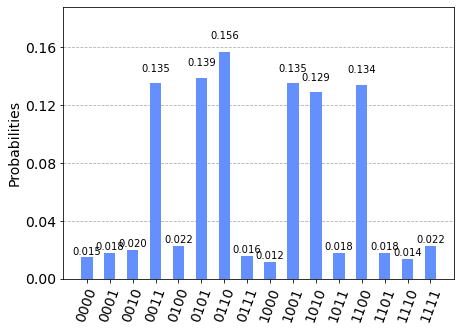

In [68]:
# Simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_sim.run(qobj).result()
plot_histogram(result.get_counts())